# Clasificación de Melanoma con EfficientNetV2-S

## Dataset: DermMel (Balanceado)

Este notebook implementa un clasificador binario de melanoma utilizando Transfer Learning con EfficientNetV2-S preentrenado en ImageNet.

**Características del dataset:**
- **Balanceado**: Igual cantidad de melanomas y no melanomas
- **División**: train_sep / valid / test
- **Estructura**: Ya organizado en carpetas por clase

## 1. Configuración Inicial y Librerías

In [4]:
import kagglehub

# Download latest version
dataset_path = kagglehub.dataset_download("drscarlat/melanoma")

print("Path to dataset files:", dataset_path)

Path to dataset files: /kaggle/input/melanoma


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
from glob import glob

# Configuración de visualización
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline
pd.set_option('display.max_columns', None)

In [6]:
# Ruta al dataset DermMel
dataset_path = '/kaggle/input/melanoma/DermMel'

# Verificar estructura
for split in ['train_sep', 'valid', 'test']:
    split_path = os.path.join(dataset_path, split)
    melanoma_count = len(os.listdir(os.path.join(split_path, 'Melanoma')))
    not_melanoma_count = len(os.listdir(os.path.join(split_path, 'NotMelanoma')))
    print(f"\n{split.upper()}:")
    print(f"  Melanoma: {melanoma_count}")
    print(f"  NotMelanoma: {not_melanoma_count}")
    print(f"  Total: {melanoma_count + not_melanoma_count}")


TRAIN_SEP:
  Melanoma: 5341
  NotMelanoma: 5341
  Total: 10682

VALID:
  Melanoma: 1781
  NotMelanoma: 1781
  Total: 3562

TEST:
  Melanoma: 1781
  NotMelanoma: 1780
  Total: 3561


## 2. Visualización de Ejemplos del Dataset

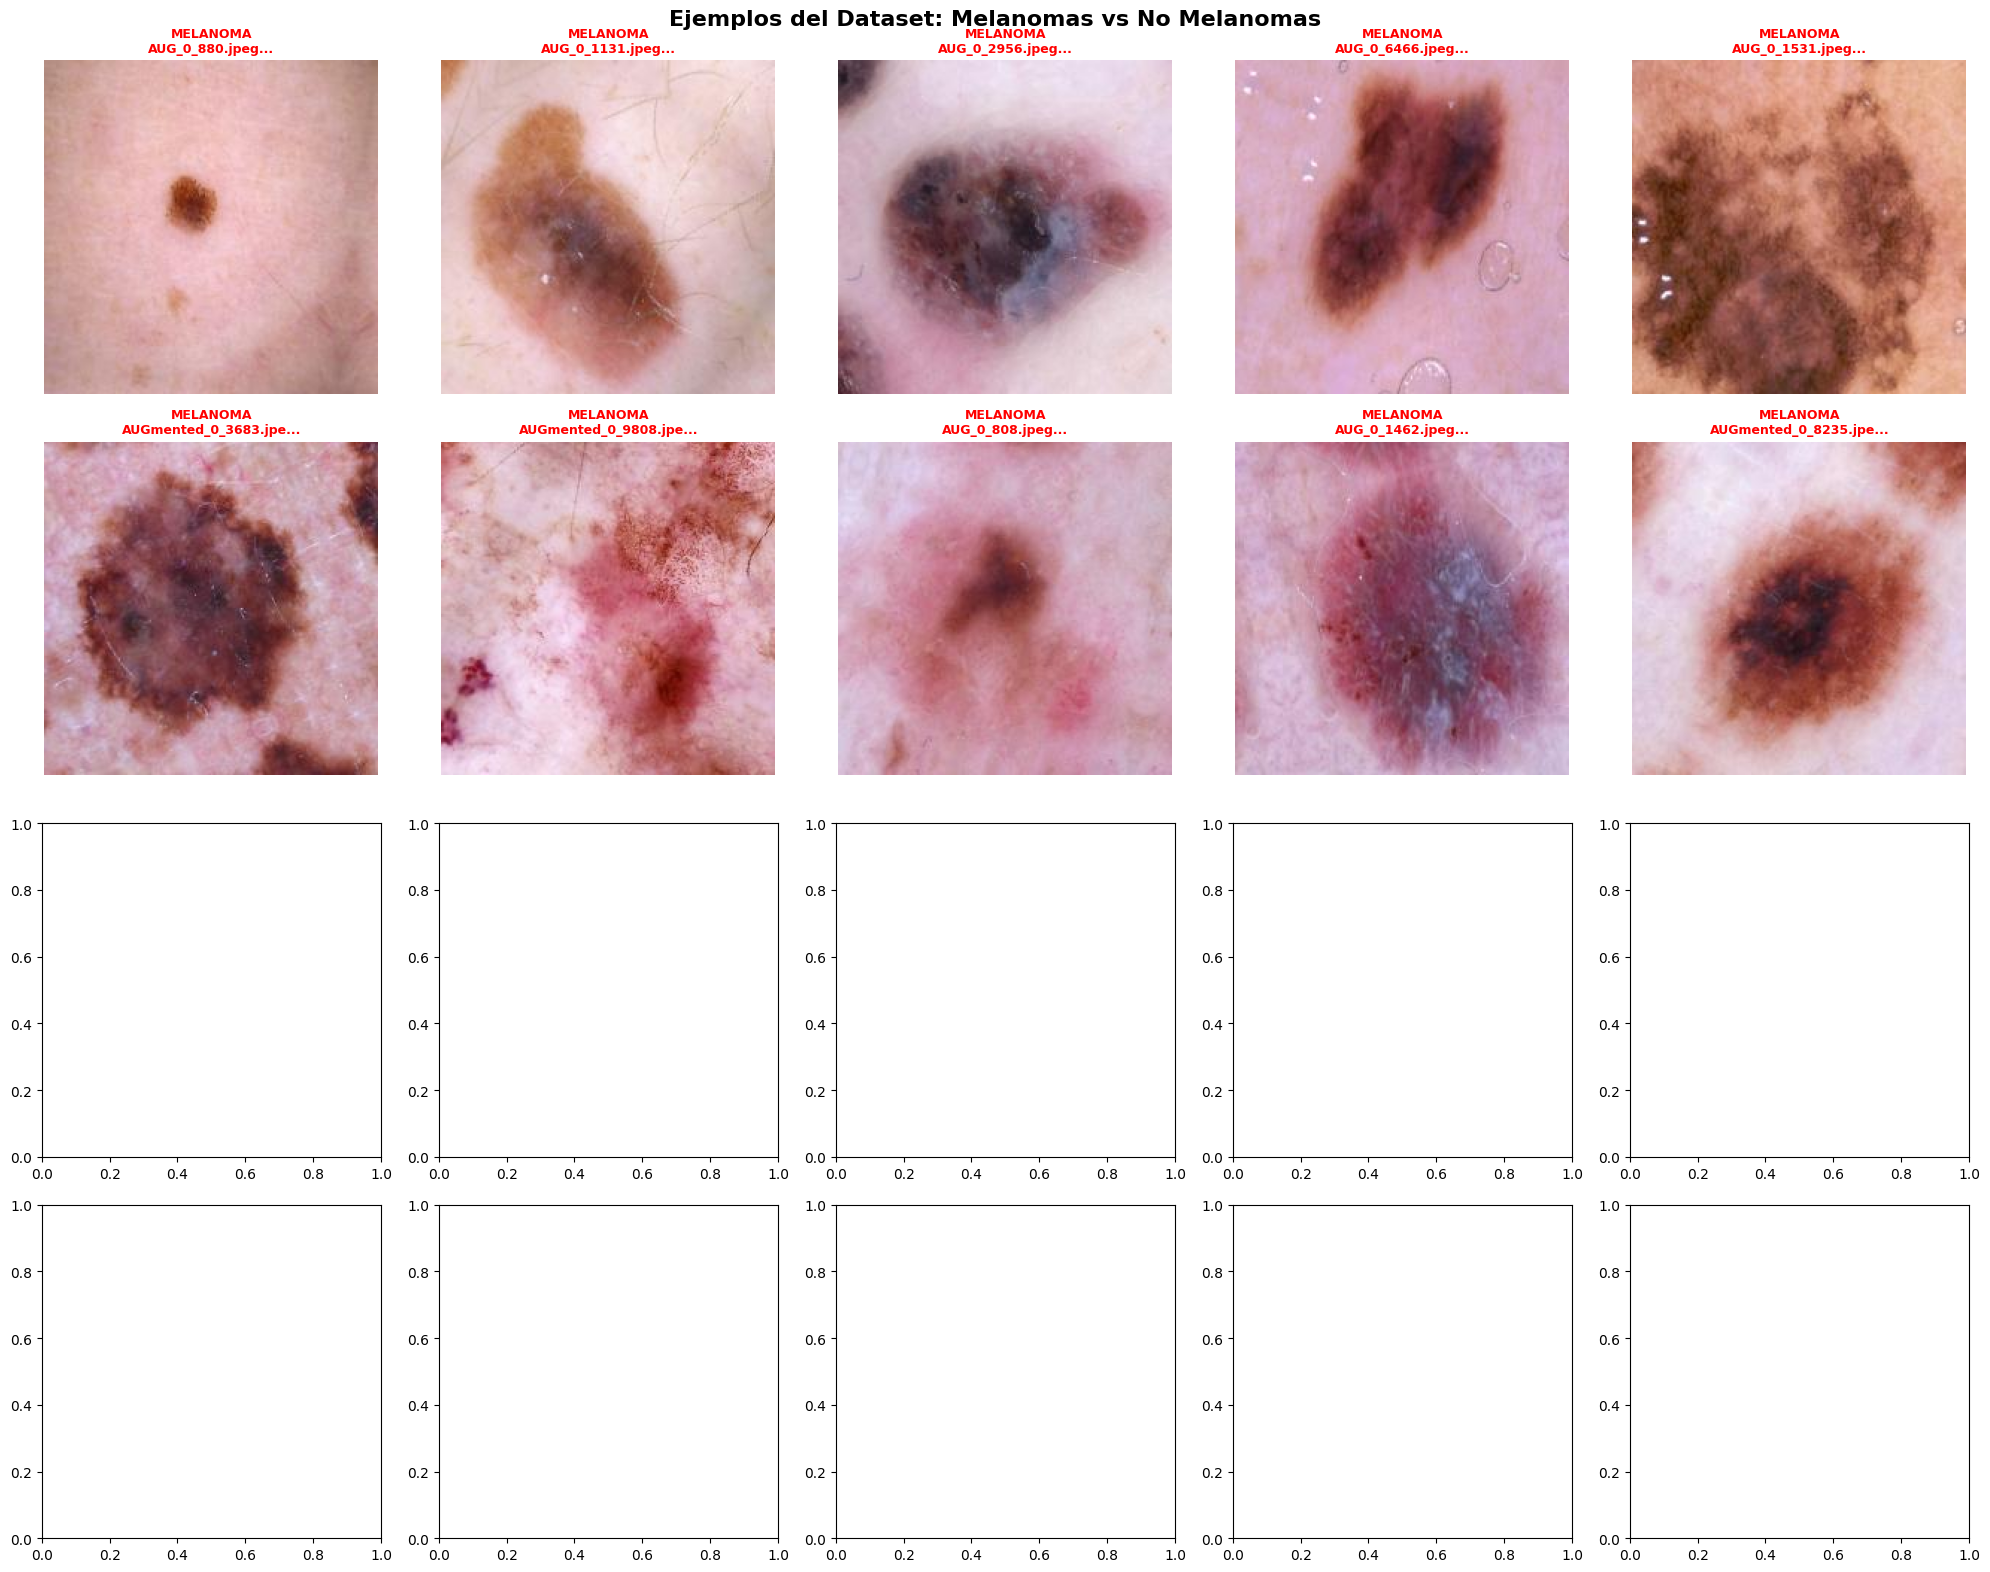


✓ Dataset balanceado: igual número de melanomas y no melanomas


In [7]:
# Visualizar ejemplos de ambas clases
fig, axes = plt.subplots(4, 5, figsize=(20, 16))
fig.suptitle('Ejemplos del Dataset: Melanomas vs No Melanomas', fontsize=16, fontweight='bold')

# Obtener rutas de imágenes de train
melanoma_imgs = glob(os.path.join(dataset_path, 'train_sep/Melanoma/*.jpeg'))[:10]
not_melanoma_imgs = glob(os.path.join(dataset_path, 'train_sep/NotMelanoma/*.jpeg'))[:10]

# Mostrar melanomas (primeras 2 filas)
for idx, img_path in enumerate(melanoma_imgs):
    row = idx // 5
    col = idx % 5
    img = Image.open(img_path)
    axes[row, col].imshow(img)
    axes[row, col].set_title(f"MELANOMA\n{os.path.basename(img_path)[:20]}...", 
                             fontsize=9, color='red', fontweight='bold')
    axes[row, col].axis('off')

# Mostrar no melanomas (últimas 2 filas)
for idx, img_path in enumerate(not_melanoma_imgs):
    row = (idx // 5) + 2
    col = idx % 5
    img = Image.open(img_path)
    axes[row, col].imshow(img)
    axes[row, col].set_title(f"NO MELANOMA\n{os.path.basename(img_path)[:20]}...", 
                             fontsize=9, color='green', fontweight='bold')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

print("\n✓ Dataset balanceado: igual número de melanomas y no melanomas")

## 3. Data Augmentation

Aplicaremos **data augmentation** solo al conjunto de entrenamiento para:
- Aumentar la diversidad visual sin recolectar más datos
- Reducir **overfitting** 
- Mejorar la capacidad de **generalización**

**Augmentation aplicado:**
- Rotaciones moderadas (±15°)
- Flips horizontales
- Zoom aleatorio (90%-110%)
- Desplazamiento (±10%)
- Variación de brillo (±10%)

**Nota:** Validación y Test NO usan augmentation para medir el desempeño real.

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

# Configuración
IMG_SIZE = 224  # EfficientNetV2-S espera 224x224
BATCH_SIZE = 32
RANDOM_STATE = 42

# Data augmentation para entrenamiento
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # Normalización de EfficientNetV2
    rotation_range=15,
    width_shift_range=0.10,
    height_shift_range=0.10,
    shear_range=0.03,
    zoom_range=0.10,
    brightness_range=[0.90, 1.10],
    horizontal_flip=True,
    fill_mode='reflect'
)

# Sin augmentation para validación y test
val_test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

print("="*60)
print("DATA AUGMENTATION CONFIGURADO")
print("="*60)
print(f"\nImagen de entrada: {IMG_SIZE}x{IMG_SIZE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Preprocesamiento: EfficientNetV2 preprocess_input")
print("="*60)

DATA AUGMENTATION CONFIGURADO

Imagen de entrada: 224x224
Batch size: 32
Preprocesamiento: EfficientNetV2 preprocess_input


## 4. Crear Generadores de Datos

Usaremos `flow_from_directory()` que carga imágenes directamente desde carpetas, ideal para nuestro dataset ya organizado.

In [9]:
# Crear generadores
train_generator = train_datagen.flow_from_directory(
    os.path.join(dataset_path, 'train_sep'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True,
    seed=RANDOM_STATE
)

val_generator = val_test_datagen.flow_from_directory(
    os.path.join(dataset_path, 'valid'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    os.path.join(dataset_path, 'test'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

print("="*60)
print("GENERADORES CREADOS")
print("="*60)
print(f"\nTrain: {train_generator.samples} imágenes")
print(f"Validation: {val_generator.samples} imágenes")
print(f"Test: {test_generator.samples} imágenes")
print(f"\nClases: {train_generator.class_indices}")
print("="*60)

Found 10682 images belonging to 2 classes.
Found 3562 images belonging to 2 classes.
Found 3561 images belonging to 2 classes.
GENERADORES CREADOS

Train: 10682 imágenes
Validation: 3562 imágenes
Test: 3561 imágenes

Clases: {'Melanoma': 0, 'NotMelanoma': 1}


In [10]:
# Hiperparámetros del modelo
DROPOUT_RATE = 0.4
DENSE_UNITS = 128

# Etapa 1 (solo cabeza)
LR_STAGE1 = 0.001
EPOCHS_STAGE1 = 10
PATIENCE_STAGE1 = 5

# Etapa 2 (fine-tuning)
LR_STAGE2 = 0.00001
EPOCHS_STAGE2 = 20
PATIENCE_STAGE2 = 7
UNFREEZE_FROM = 100

print("Hiperparámetros configurados")

Hiperparámetros configurados


### Nota: Para verificación rápida

Para probar el funcionamiento completo del notebook sin esperar horas, puedes usar estos valores reducidos:
- EPOCHS_STAGE1 = 2
- EPOCHS_STAGE2 = 2

Para entrenamiento completo, usa los valores originales:
- EPOCHS_STAGE1 = 10
- EPOCHS_STAGE2 = 20

In [11]:
# Configuración para prueba rápida (descomentar para testing)
EPOCHS_STAGE1 = 2  # Reducido para prueba
EPOCHS_STAGE2 = 2  # Reducido para prueba
print(f"⚠️ MODO PRUEBA: {EPOCHS_STAGE1} épocas por etapa")

⚠️ MODO PRUEBA: 2 épocas por etapa


### 5.1. Configuración de Hiperparámetros

### 5.2. Construcción del Modelo

In [12]:
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

# Cargar EfficientNetV2-S sin la capa de clasificación
base_model = EfficientNetV2S(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# Congelar el backbone inicialmente
base_model.trainable = False

# Construir la cabeza de clasificación
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(DENSE_UNITS, activation='relu')(x)
x = Dropout(DROPOUT_RATE)(x)
output = Dense(1, activation='sigmoid')(x)

# Crear el modelo completo
model = Model(inputs=base_model.input, outputs=output)

# Contar parámetros
trainable_params = sum([np.prod(v.shape) for v in model.trainable_weights])
non_trainable_params = sum([np.prod(v.shape) for v in model.non_trainable_weights])

print("="*60)
print("MODELO CREADO")
print("="*60)
print(f"Backbone: EfficientNetV2-S (ImageNet)")
print(f"Parámetros entrenables: {trainable_params:,}")
print(f"Parámetros congelados: {non_trainable_params:,}")
print("="*60)

I0000 00:00:1763748181.352216      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1763748181.352849      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
MODELO CREADO
Backbone: EfficientNetV2-S (ImageNet)
Parámetros entrenables: 164,097
Parámetros congelados: 20,331,360


### 5.3. Etapa 1: Entrenar Solo la Cabeza

In [13]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.metrics import AUC, Precision, Recall

# Compilar el modelo
model.compile(
    optimizer=Adam(learning_rate=LR_STAGE1),
    loss='binary_crossentropy',
    metrics=['accuracy', AUC(name='auc'), Precision(name='precision'), Recall(name='recall')]
)

# Callbacks
checkpoint_stage1 = ModelCheckpoint(
    'best_model_stage1.keras',
    monitor='val_auc',
    mode='max',
    save_best_only=True,
    verbose=1
)

early_stopping_stage1 = EarlyStopping(
    monitor='val_auc',
    mode='max',
    patience=PATIENCE_STAGE1,
    restore_best_weights=True,
    verbose=1
)

print("Modelo compilado para Etapa 1")

Modelo compilado para Etapa 1


In [14]:
# Entrenar Etapa 1
print("="*60)
print("ENTRENANDO ETAPA 1 - SOLO CABEZA")
print("="*60)

history_stage1 = model.fit(
    train_generator,
    epochs=EPOCHS_STAGE1,
    validation_data=val_generator,
    callbacks=[checkpoint_stage1, early_stopping_stage1],
    verbose=1
)

print("\nEtapa 1 completada")

ENTRENANDO ETAPA 1 - SOLO CABEZA


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/2


I0000 00:00:1763748211.171112     117 service.cc:148] XLA service 0x79657c0040c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763748211.171993     117 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1763748211.172014     117 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1763748214.883981     117 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/334 ━━━━━━━━━━━━━━━━━━━━ 4:12:31 46s/step - accuracy: 0.5938 - auc: 0.5392 - loss: 0.7424 - precision: 1.0000 - recall: 0.1333

I0000 00:00:1763748234.608408     117 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 671ms/step - accuracy: 0.8646 - auc: 0.9275 - loss: 0.3314 - precision: 0.8660 - recall: 0.8538
Epoch 1: val_auc improved from -inf to 0.97959, saving model to best_model_stage1.keras
334/334 ━━━━━━━━━━━━━━━━━━━━ 310s 794ms/step - accuracy: 0.8646 - auc: 0.9276 - loss: 0.3312 - precision: 0.8660 - recall: 0.8539 - val_accuracy: 0.9298 - val_auc: 0.9796 - val_loss: 0.1721 - val_precision: 0.9176 - val_recall: 0.9444
Epoch 2/2
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - accuracy: 0.9158 - auc: 0.9660 - loss: 0.2219 - precision: 0.8978 - recall: 0.9401
Epoch 2: val_auc did not improve from 0.97959
334/334 ━━━━━━━━━━━━━━━━━━━━ 178s 533ms/step - accuracy: 0.9158 - auc: 0.9660 - loss: 0.2219 - precision: 0.8978 - recall: 0.9401 - val_accuracy: 0.9394 - val_auc: 0.9795 - val_loss: 0.1671 - val_precision: 0.9027 - val_recall: 0.9848
Restoring model weights from the end of the best epoch: 1.

Etapa 1 completada


### 5.4. Etapa 2: Fine-Tuning

In [15]:
# Descongelar el backbone
base_model.trainable = True

# Congelar las primeras capas
for layer in base_model.layers[:UNFREEZE_FROM]:
    layer.trainable = False

# Contar parámetros
trainable_params_stage2 = sum([np.prod(v.shape) for v in model.trainable_weights])

print("="*60)
print("DESCONGELADO PARA FINE-TUNING")
print("="*60)
print(f"Capas descongeladas: {len(base_model.layers) - UNFREEZE_FROM}")
print(f"Parámetros entrenables: {trainable_params_stage2:,}")
print("="*60)

DESCONGELADO PARA FINE-TUNING
Capas descongeladas: 413
Parámetros entrenables: 19,133,001


In [16]:
# Re-compilar con learning rate muy bajo
model.compile(
    optimizer=Adam(learning_rate=LR_STAGE2),
    loss='binary_crossentropy',
    metrics=['accuracy', AUC(name='auc'), Precision(name='precision'), Recall(name='recall')]
)

# Callbacks
checkpoint_stage2 = ModelCheckpoint(
    'best_model_stage2.keras',
    monitor='val_auc',
    mode='max',
    save_best_only=True,
    verbose=1
)

early_stopping_stage2 = EarlyStopping(
    monitor='val_auc',
    mode='max',
    patience=PATIENCE_STAGE2,
    restore_best_weights=True,
    verbose=1
)

print("Modelo recompilado para Etapa 2")

Modelo recompilado para Etapa 2


In [17]:
# Entrenar Etapa 2
print("="*60)
print("ENTRENANDO ETAPA 2 - FINE-TUNING")
print("="*60)

history_stage2 = model.fit(
    train_generator,
    epochs=EPOCHS_STAGE2,
    validation_data=val_generator,
    callbacks=[checkpoint_stage2, early_stopping_stage2],
    verbose=1
)

print("\nFine-tuning completado")

ENTRENANDO ETAPA 2 - FINE-TUNING
Epoch 1/2


E0000 00:00:1763748763.225737     119 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1763748763.367839     119 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1763748763.778577     119 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1763748763.924953     119 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


144/334 ━━━━━━━━━━━━━━━━━━━━ 1:33 494ms/step - accuracy: 0.8811 - auc: 0.9400 - loss: 0.3046 - precision: 0.8803 - recall: 0.8878

E0000 00:00:1763748882.731937     117 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1763748882.871429     117 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1763748883.310128     117 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1763748883.452401     117 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 639ms/step - accuracy: 0.8961 - auc: 0.9488 - loss: 0.2726 - precision: 0.8835 - recall: 0.9152
Epoch 1: val_auc improved from -inf to 0.97883, saving model to best_model_stage2.keras
334/334 ━━━━━━━━━━━━━━━━━━━━ 362s 739ms/step - accuracy: 0.8962 - auc: 0.9488 - loss: 0.2724 - precision: 0.8835 - recall: 0.9153 - val_accuracy: 0.9394 - val_auc: 0.9788 - val_loss: 0.1545 - val_precision: 0.9011 - val_recall: 0.9871
Epoch 2/2
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - accuracy: 0.9325 - auc: 0.9751 - loss: 0.1776 - precision: 0.9001 - recall: 0.9739
Epoch 2: val_auc improved from 0.97883 to 0.98295, saving model to best_model_stage2.keras
334/334 ━━━━━━━━━━━━━━━━━━━━ 186s 557ms/step - accuracy: 0.9325 - auc: 0.9751 - loss: 0.1776 - precision: 0.9000 - recall: 0.9739 - val_accuracy: 0.9436 - val_auc: 0.9830 - val_loss: 0.1413 - val_precision: 0.9089 - val_recall: 0.9860
Restoring model weights from the end of the best epoch: 2.

Fine-tuning completado


### 5.5. Visualización de Curvas de Entrenamiento

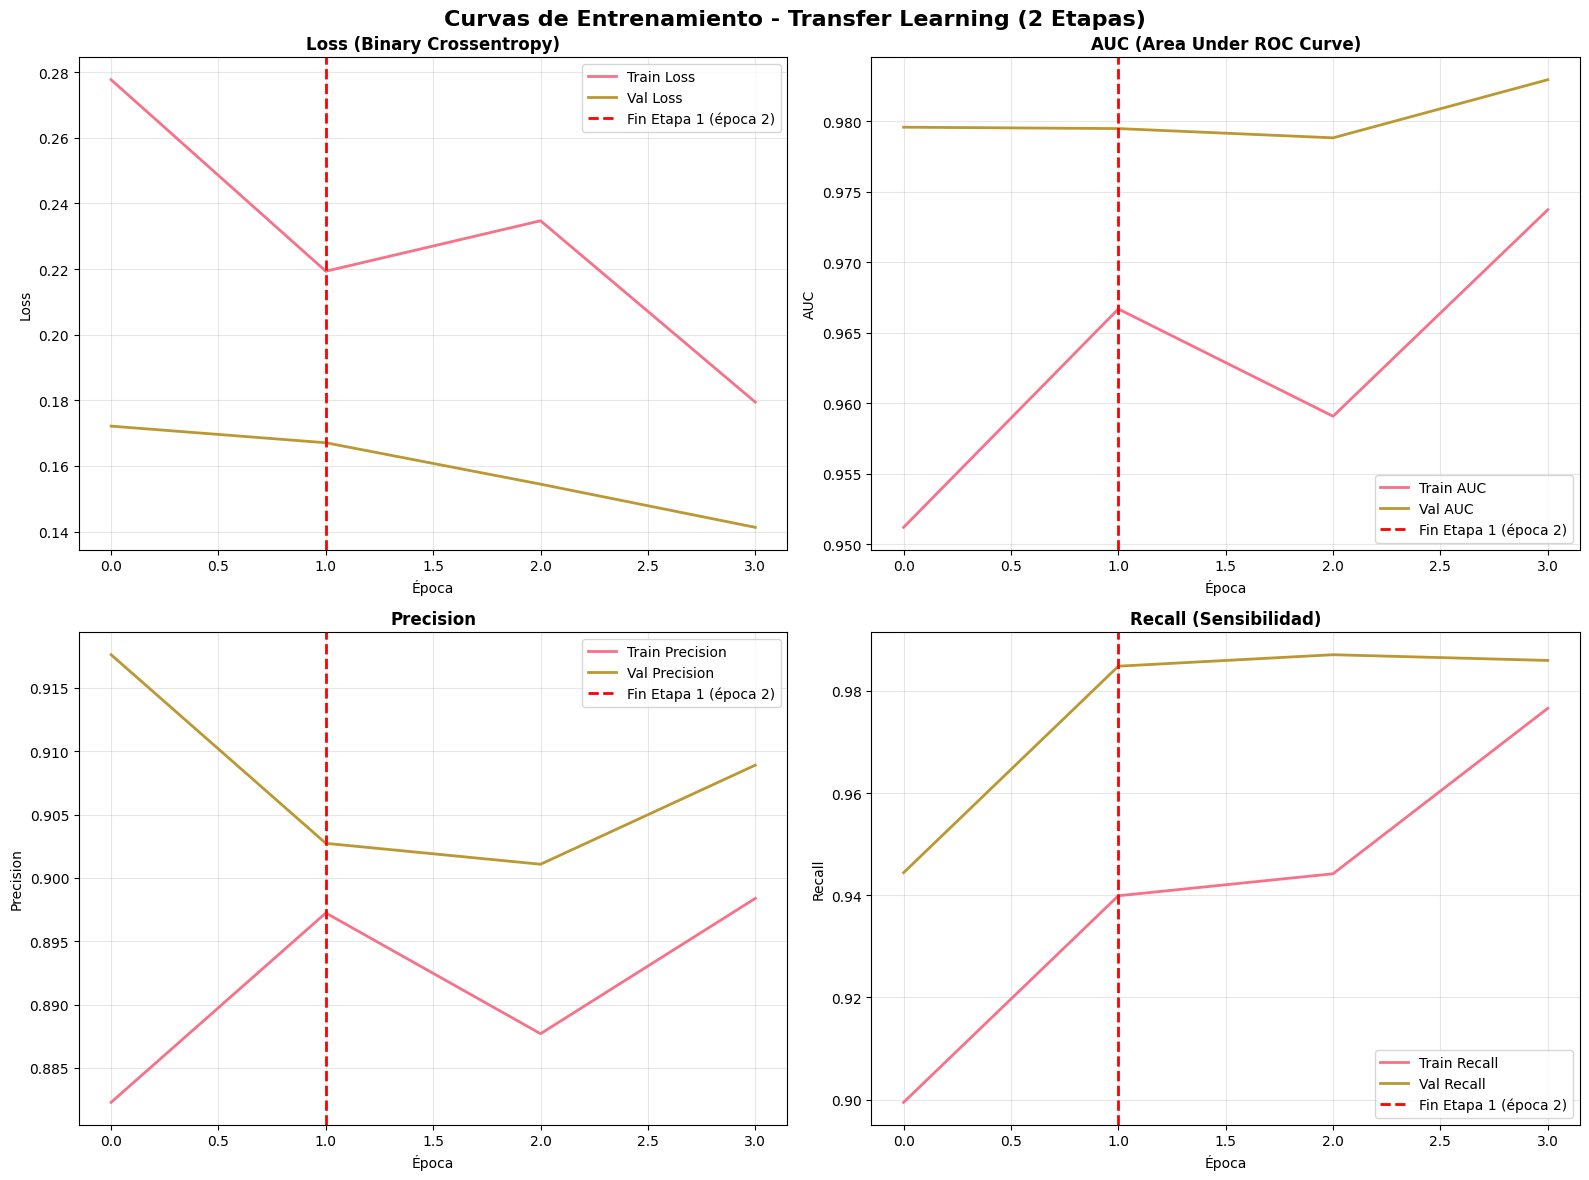


Gráfico guardado en: training_curves_finetuning.png


In [18]:
import matplotlib.pyplot as plt

# Combinar historiales de ambas etapas
def combine_histories(hist1, hist2):
    """Combina dos historiales de entrenamiento"""
    combined = {}
    for key in hist1.history.keys():
        combined[key] = hist1.history[key] + hist2.history[key]
    return combined

combined_history = combine_histories(history_stage1, history_stage2)

# Configurar la figura
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Curvas de Entrenamiento - Transfer Learning (2 Etapas)', 
             fontsize=16, fontweight='bold')

# Marcar la separación entre etapas
epoch_split = len(history_stage1.history['loss'])
total_epochs = len(combined_history['loss'])

# Gráfico 1: Loss
ax1 = axes[0, 0]
ax1.plot(combined_history['loss'], label='Train Loss', linewidth=2)
ax1.plot(combined_history['val_loss'], label='Val Loss', linewidth=2)
ax1.axvline(x=epoch_split-1, color='red', linestyle='--', linewidth=2, 
            label=f'Fin Etapa 1 (época {epoch_split})')
ax1.set_title('Loss (Binary Crossentropy)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Época')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(alpha=0.3)

# Gráfico 2: AUC
ax2 = axes[0, 1]
ax2.plot(combined_history['auc'], label='Train AUC', linewidth=2)
ax2.plot(combined_history['val_auc'], label='Val AUC', linewidth=2)
ax2.axvline(x=epoch_split-1, color='red', linestyle='--', linewidth=2,
            label=f'Fin Etapa 1 (época {epoch_split})')
ax2.set_title('AUC (Area Under ROC Curve)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Época')
ax2.set_ylabel('AUC')
ax2.legend()
ax2.grid(alpha=0.3)

# Gráfico 3: Precision
ax3 = axes[1, 0]
ax3.plot(combined_history['precision'], label='Train Precision', linewidth=2)
ax3.plot(combined_history['val_precision'], label='Val Precision', linewidth=2)
ax3.axvline(x=epoch_split-1, color='red', linestyle='--', linewidth=2,
            label=f'Fin Etapa 1 (época {epoch_split})')
ax3.set_title('Precision', fontsize=12, fontweight='bold')
ax3.set_xlabel('Época')
ax3.set_ylabel('Precision')
ax3.legend()
ax3.grid(alpha=0.3)

# Gráfico 4: Recall
ax4 = axes[1, 1]
ax4.plot(combined_history['recall'], label='Train Recall', linewidth=2)
ax4.plot(combined_history['val_recall'], label='Val Recall', linewidth=2)
ax4.axvline(x=epoch_split-1, color='red', linestyle='--', linewidth=2,
            label=f'Fin Etapa 1 (época {epoch_split})')
ax4.set_title('Recall (Sensibilidad)', fontsize=12, fontweight='bold')
ax4.set_xlabel('Época')
ax4.set_ylabel('Recall')
ax4.legend()
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves_finetuning.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nGráfico guardado en: training_curves_finetuning.png")

In [19]:
# Resumen de resultados finales
print("="*60)
print("RESUMEN DEL ENTRENAMIENTO")
print("="*60)

print(f"\nETAPA 1 (Solo cabeza - {len(history_stage1.history['loss'])} épocas):")
print(f"  Train Loss: {history_stage1.history['loss'][-1]:.4f}")
print(f"  Val Loss:   {history_stage1.history['val_loss'][-1]:.4f}")
print(f"  Train AUC:  {history_stage1.history['auc'][-1]:.4f}")
print(f"  Val AUC:    {history_stage1.history['val_auc'][-1]:.4f}")

print(f"\nETAPA 2 (Fine-tuning - {len(history_stage2.history['loss'])} épocas):")
print(f"  Train Loss: {history_stage2.history['loss'][-1]:.4f}")
print(f"  Val Loss:   {history_stage2.history['val_loss'][-1]:.4f}")
print(f"  Train AUC:  {history_stage2.history['auc'][-1]:.4f}")
print(f"  Val AUC:    {history_stage2.history['val_auc'][-1]:.4f}")

print(f"\nMEJOR MODELO (guardado):")
best_val_auc = max(combined_history['val_auc'])
best_epoch = combined_history['val_auc'].index(best_val_auc) + 1
print(f"  Mejor Val AUC: {best_val_auc:.4f} (época {best_epoch})")
print(f"  Archivo: best_model_stage2.keras")

print("\n" + "="*60)
print("FINE-TUNING COMPLETADO EXITOSAMENTE")
print("="*60)
print("\nPróximos pasos:")
print("  1. Evaluar el modelo en el conjunto de test")
print("  2. Calcular métricas detalladas (ROC-AUC, PR-AUC, Confusion Matrix)")
print("  3. Ajustar umbral de decisión para maximizar recall")
print("  4. Implementar XAI (Grad-CAM) para interpretabilidad")
print("\n" + "="*60)

RESUMEN DEL ENTRENAMIENTO

ETAPA 1 (Solo cabeza - 2 épocas):
  Train Loss: 0.2193
  Val Loss:   0.1671
  Train AUC:  0.9667
  Val AUC:    0.9795

ETAPA 2 (Fine-tuning - 2 épocas):
  Train Loss: 0.1795
  Val Loss:   0.1413
  Train AUC:  0.9737
  Val AUC:    0.9830

MEJOR MODELO (guardado):
  Mejor Val AUC: 0.9830 (época 4)
  Archivo: best_model_stage2.keras

FINE-TUNING COMPLETADO EXITOSAMENTE

Próximos pasos:
  1. Evaluar el modelo en el conjunto de test
  2. Calcular métricas detalladas (ROC-AUC, PR-AUC, Confusion Matrix)
  3. Ajustar umbral de decisión para maximizar recall
  4. Implementar XAI (Grad-CAM) para interpretabilidad



## 6. Evaluación del Modelo

### 6.1. Generar Predicciones en Test

In [20]:
from tensorflow.keras.models import load_model

# Cargar el mejor modelo
best_model = load_model('best_model_stage2.keras')
print("Mejor modelo cargado")

Mejor modelo cargado


### 6.2. Calcular Métricas

In [21]:
# Resetear el generador de test
test_generator.reset()

# Generar predicciones
y_pred_proba = best_model.predict(test_generator, verbose=1).flatten()

# Obtener etiquetas verdaderas
y_test = test_generator.classes

# Predicciones binarias (umbral 0.5)
y_pred = (y_pred_proba >= 0.5).astype(int)

print(f"\nPredicciones generadas: {len(y_pred)}")

112/112 ━━━━━━━━━━━━━━━━━━━━ 44s 321ms/step

Predicciones generadas: 3561


### 6.3. Métricas de Evaluación

In [23]:
from sklearn.metrics import (
    roc_auc_score, 
    average_precision_score,
    confusion_matrix, 
    classification_report,
    roc_curve,
    precision_recall_curve
)

# Calcular ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Calcular PR-AUC (Precision-Recall AUC)
pr_auc = average_precision_score(y_test, y_pred_proba)

# Matriz de confusión con umbral por defecto (0.5)
cm_default = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm_default.ravel()

# Métricas derivadas
sensitivity_default = tp / (tp + fn) if (tp + fn) > 0 else 0  # Recall
specificity_default = tn / (tn + fp) if (tn + fp) > 0 else 0
precision_default = tp / (tp + fp) if (tp + fp) > 0 else 0
f1_default = 2 * (precision_default * sensitivity_default) / (precision_default + sensitivity_default) if (precision_default + sensitivity_default) > 0 else 0

print("="*60)
print("MÉTRICAS DE EVALUACIÓN - TEST SET")
print("="*60)

print(f"\nMÉTRICAS GENERALES:")
print(f"  ROC-AUC:     {roc_auc:.4f}")
print(f"  PR-AUC:      {pr_auc:.4f}")

print(f"\nMÉTRICAS CON UMBRAL 0.5:")
print(f"  Sensibilidad (Recall):  {sensitivity_default:.4f} ({100*sensitivity_default:.1f}%)")
print(f"  Especificidad:          {specificity_default:.4f} ({100*specificity_default:.1f}%)")
print(f"  Precisión:              {precision_default:.4f} ({100*precision_default:.1f}%)")
print(f"  F1-Score:               {f1_default:.4f}")

print(f"\nMATRIZ DE CONFUSIÓN (umbral 0.5):")
print(f"  ┌─────────────────────────┐")
print(f"  │  TN={tn:<6}  FP={fp:<6}  │")
print(f"  │  FN={fn:<6}  TP={tp:<6}  │")
print(f"  └─────────────────────────┘")
print(f"\n  Verdaderos Negativos (TN): {tn}")
print(f"  Falsos Positivos (FP):     {fp}")
print(f"  Falsos Negativos (FN):     {fn}  [Crítico en contexto clínico]")
print(f"  Verdaderos Positivos (TP): {tp}")

print("\n" + "="*60)

MÉTRICAS DE EVALUACIÓN - TEST SET

MÉTRICAS GENERALES:
  ROC-AUC:     0.9770
  PR-AUC:      0.9724

MÉTRICAS CON UMBRAL 0.5:
  Sensibilidad (Recall):  0.9803 (98.0%)
  Especificidad:          0.8866 (88.7%)
  Precisión:              0.8963 (89.6%)
  F1-Score:               0.9364

MATRIZ DE CONFUSIÓN (umbral 0.5):
  ┌─────────────────────────┐
  │  TN=1579    FP=202     │
  │  FN=35      TP=1745    │
  └─────────────────────────┘

  Verdaderos Negativos (TN): 1579
  Falsos Positivos (FP):     202
  Falsos Negativos (FN):     35  [Crítico en contexto clínico]
  Verdaderos Positivos (TP): 1745



### 6.4. Curva ROC

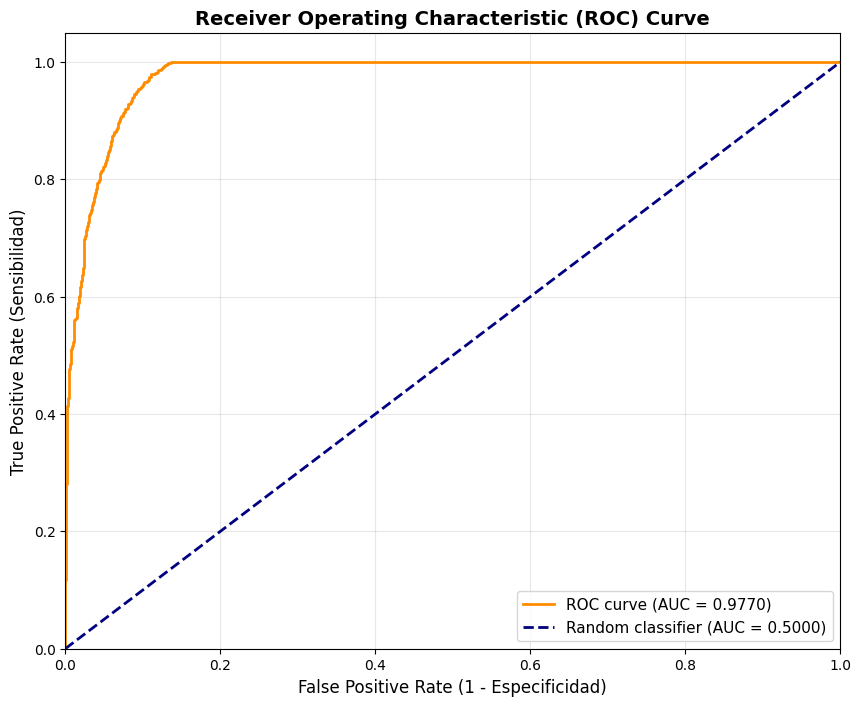

Curva ROC guardada en: roc_curve.png


In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Calcular curva ROC
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_proba)

# Crear figura
plt.figure(figsize=(10, 8))

# Plotear curva ROC
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (AUC = {roc_auc:.4f})')

# Línea de clasificador aleatorio
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
         label='Random classifier (AUC = 0.5000)')

# Configuración
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Especificidad)', fontsize=12)
plt.ylabel('True Positive Rate (Sensibilidad)', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.3)

# Guardar y mostrar
plt.savefig('roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print("Curva ROC guardada en: roc_curve.png")

### 6.5. Curva Precision-Recall

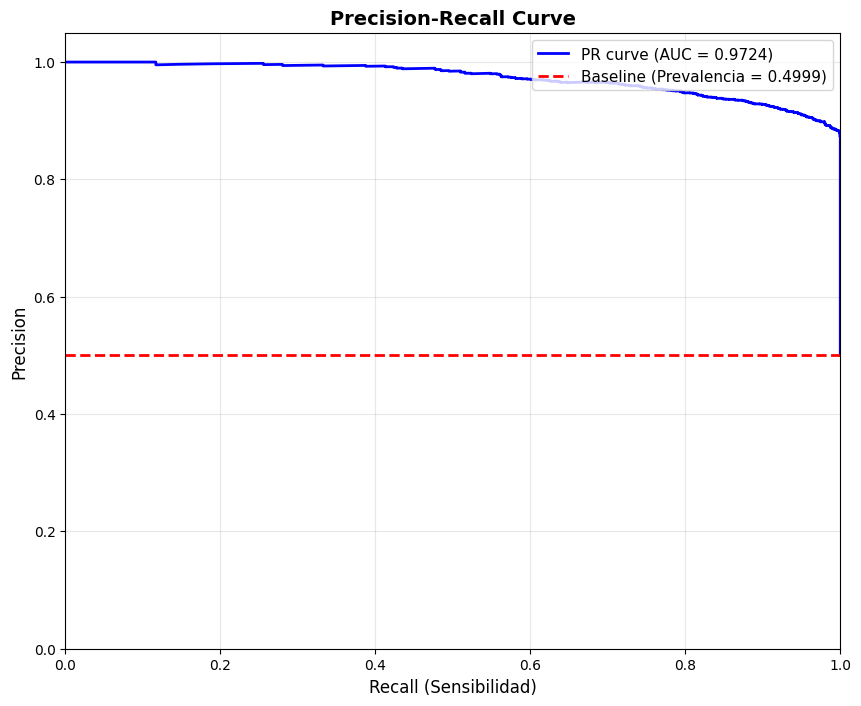

Curva Precision-Recall guardada en: precision_recall_curve.png


In [25]:
# Calcular curva Precision-Recall
precision_curve, recall_curve, thresholds_pr = precision_recall_curve(y_test, y_pred_proba)

# Calcular baseline (proporción de positivos)
baseline = y_test.sum() / len(y_test)

# Crear figura
plt.figure(figsize=(10, 8))

# Plotear curva PR
plt.plot(recall_curve, precision_curve, color='blue', lw=2,
         label=f'PR curve (AUC = {pr_auc:.4f})')

# Línea baseline
plt.axhline(y=baseline, color='red', linestyle='--', lw=2,
            label=f'Baseline (Prevalencia = {baseline:.4f})')

# Configuración
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall (Sensibilidad)', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve', fontsize=14, fontweight='bold')
plt.legend(loc="upper right", fontsize=11)
plt.grid(alpha=0.3)

# Guardar y mostrar
plt.savefig('precision_recall_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print("Curva Precision-Recall guardada en: precision_recall_curve.png")

### 6.6. Matriz de Confusión

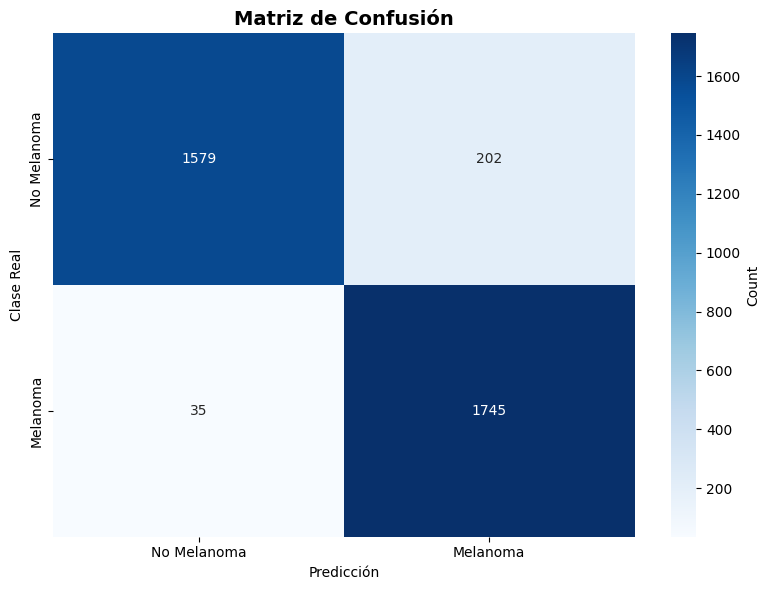


TN=1579, FP=202, FN=35, TP=1745


In [26]:
# Simplificado - solo mostrar la matriz de confusión con umbral 0.5
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Melanoma', 'Melanoma'],
            yticklabels=['No Melanoma', 'Melanoma'],
            cbar_kws={'label': 'Count'})
plt.title('Matriz de Confusión', fontsize=14, fontweight='bold')
plt.ylabel('Clase Real')
plt.xlabel('Predicción')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

tn, fp, fn, tp = cm.ravel()
print(f"\nTN={tn}, FP={fp}, FN={fn}, TP={tp}")

## 7. Explainable AI (XAI) - Grad-CAM

Implementaremos Grad-CAM para visualizar qué regiones de la imagen influyen en las predicciones del modelo.

### 7.1. Funciones de Grad-CAM

In [27]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Model

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """
    Genera un mapa de calor Grad-CAM para una imagen.
    
    Args:
        img_array: Imagen preprocesada (batch_size, height, width, channels)
        model: Modelo de Keras
        last_conv_layer_name: Nombre de la última capa convolucional
        pred_index: Índice de la clase a visualizar (None = clase predicha)
    
    Returns:
        heatmap: Mapa de calor normalizado [0, 1]
    """
    # Crear un modelo que mapea la entrada a las activaciones de la última conv
    # y a las predicciones finales
    grad_model = Model(
        inputs=model.input,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    # Calcular el gradiente de la clase predicha con respecto a las activaciones
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            # Para clasificación binaria, usamos el valor escalar de salida
            class_channel = preds[:, 0]
        else:
            class_channel = preds[:, pred_index]
    
    # Gradiente de la salida de clase con respecto a la última capa conv
    grads = tape.gradient(class_channel, last_conv_layer_output)
    
    # Verificar que los gradientes no sean None
    if grads is None:
        print(f"Warning: No gradients computed for layer {last_conv_layer_name}")
        # Retornar un heatmap vacío del tamaño correcto
        return np.zeros((7, 7))  # Tamaño típico de salida de EfficientNet
    
    # Vector de importancia: promedio de gradientes por canal
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # Multiplicar cada canal por su importancia
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    
    # Normalizar el heatmap entre 0 y 1 para visualización
    max_val = tf.math.reduce_max(heatmap)
    if max_val > 0:
        heatmap = tf.maximum(heatmap, 0) / max_val
    else:
        heatmap = tf.maximum(heatmap, 0)
    
    return heatmap.numpy()


def overlay_gradcam(img, heatmap, alpha=0.4, colormap=cv2.COLORMAP_JET):
    """
    Superpone un heatmap Grad-CAM sobre una imagen.
    
    Args:
        img: Imagen original (H, W, 3) en rango [0, 255]
        heatmap: Mapa de calor normalizado [0, 1]
        alpha: Intensidad de superposición (0=solo imagen, 1=solo heatmap)
        colormap: Mapa de color de OpenCV
    
    Returns:
        Imagen con heatmap superpuesto
    """
    # Verificar que el heatmap tenga al menos 2 dimensiones
    if heatmap.ndim < 2 or heatmap.size == 0:
        print(f"Warning: Invalid heatmap dimensions {heatmap.shape}. Returning original image.")
        return img
    
    # Asegurar que el heatmap sea 2D
    if heatmap.ndim > 2:
        heatmap = np.mean(heatmap, axis=-1)
    
    # Convertir heatmap a float32 para asegurar compatibilidad con cv2.resize
    heatmap = heatmap.astype(np.float32)
    
    # Verificar que el heatmap tenga valores válidos
    if np.isnan(heatmap).any() or np.isinf(heatmap).any():
        print(f"Warning: Heatmap contains NaN or Inf values. Returning original image.")
        return img
    
    # Redimensionar heatmap al tamaño de la imagen
    try:
        heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]), 
                                     interpolation=cv2.INTER_LINEAR)
    except Exception as e:
        print(f"Warning: Error resizing heatmap: {e}. Returning original image.")
        print(f"Heatmap shape: {heatmap.shape}, dtype: {heatmap.dtype}")
        print(f"Heatmap min: {heatmap.min()}, max: {heatmap.max()}")
        return img
    
    # Normalizar el heatmap redimensionado si es necesario
    if heatmap_resized.max() > 0:
        heatmap_resized = heatmap_resized / heatmap_resized.max()
    
    # Aplicar colormap al heatmap
    heatmap_uint8 = np.uint8(255 * heatmap_resized)
    heatmap_colored = cv2.applyColorMap(heatmap_uint8, colormap)
    
    # Convertir heatmap de BGR a RGB
    heatmap_rgb = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
    
    # Asegurar que img sea uint8
    img = img.astype(np.uint8)
    
    # Superponer heatmap sobre la imagen original
    superimposed_img = heatmap_rgb * alpha + img * (1 - alpha)
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)
    
    return superimposed_img


print("="*60)
print("FUNCIONES GRAD-CAM IMPLEMENTADAS")
print("="*60)
print("\nFunciones disponibles:")
print("  - make_gradcam_heatmap(): Genera mapa de calor Grad-CAM")
print("  - overlay_gradcam(): Superpone heatmap sobre imagen original")
print("="*60)

FUNCIONES GRAD-CAM IMPLEMENTADAS

Funciones disponibles:
  - make_gradcam_heatmap(): Genera mapa de calor Grad-CAM
  - overlay_gradcam(): Superpone heatmap sobre imagen original


### 7.2. Identificar Última Capa Convolucional

In [28]:
# Buscar la última capa convolucional en el modelo
def find_last_conv_layer(model):
    """Encuentra el nombre de la última capa convolucional"""
    for layer in reversed(model.layers):
        # Buscar en el backbone (primer layer que es un modelo)
        if isinstance(layer, Model):
            for sub_layer in reversed(layer.layers):
                if 'conv' in sub_layer.name.lower():
                    return sub_layer.name
        elif 'conv' in layer.name.lower():
            return layer.name
    return None

# Identificar la última capa convolucional
last_conv_layer_name = find_last_conv_layer(best_model)

print("="*60)
print("IDENTIFICACIÓN DE CAPA CONVOLUCIONAL")
print("="*60)
print(f"\nÚltima capa convolucional encontrada: {last_conv_layer_name}")

# Verificar que la capa existe
try:
    layer = best_model.get_layer(last_conv_layer_name)
    print(f"Verificación exitosa: Capa '{last_conv_layer_name}' encontrada")
    print(f"Forma de salida: {layer.output_shape}")
except:
    print("Error: No se pudo encontrar la capa convolucional")
    # Fallback: usar una capa conocida de EfficientNetV2
    last_conv_layer_name = "top_conv"
    print(f"Usando fallback: {last_conv_layer_name}")

print("\n" + "="*60)

IDENTIFICACIÓN DE CAPA CONVOLUCIONAL

Última capa convolucional encontrada: top_conv
Verificación exitosa: Capa 'top_conv' encontrada
Error: No se pudo encontrar la capa convolucional
Usando fallback: top_conv



### 7.3. Visualizar Grad-CAM

Imágenes cargadas: 3561
Rango de valores: [0, 255]
Umbral óptimo encontrado: 0.5160
TP: 1744, TN: 1583, FP: 198, FN: 36

GENERANDO VISUALIZACIONES GRAD-CAM

Procesando Verdaderos Positivos (TP)...


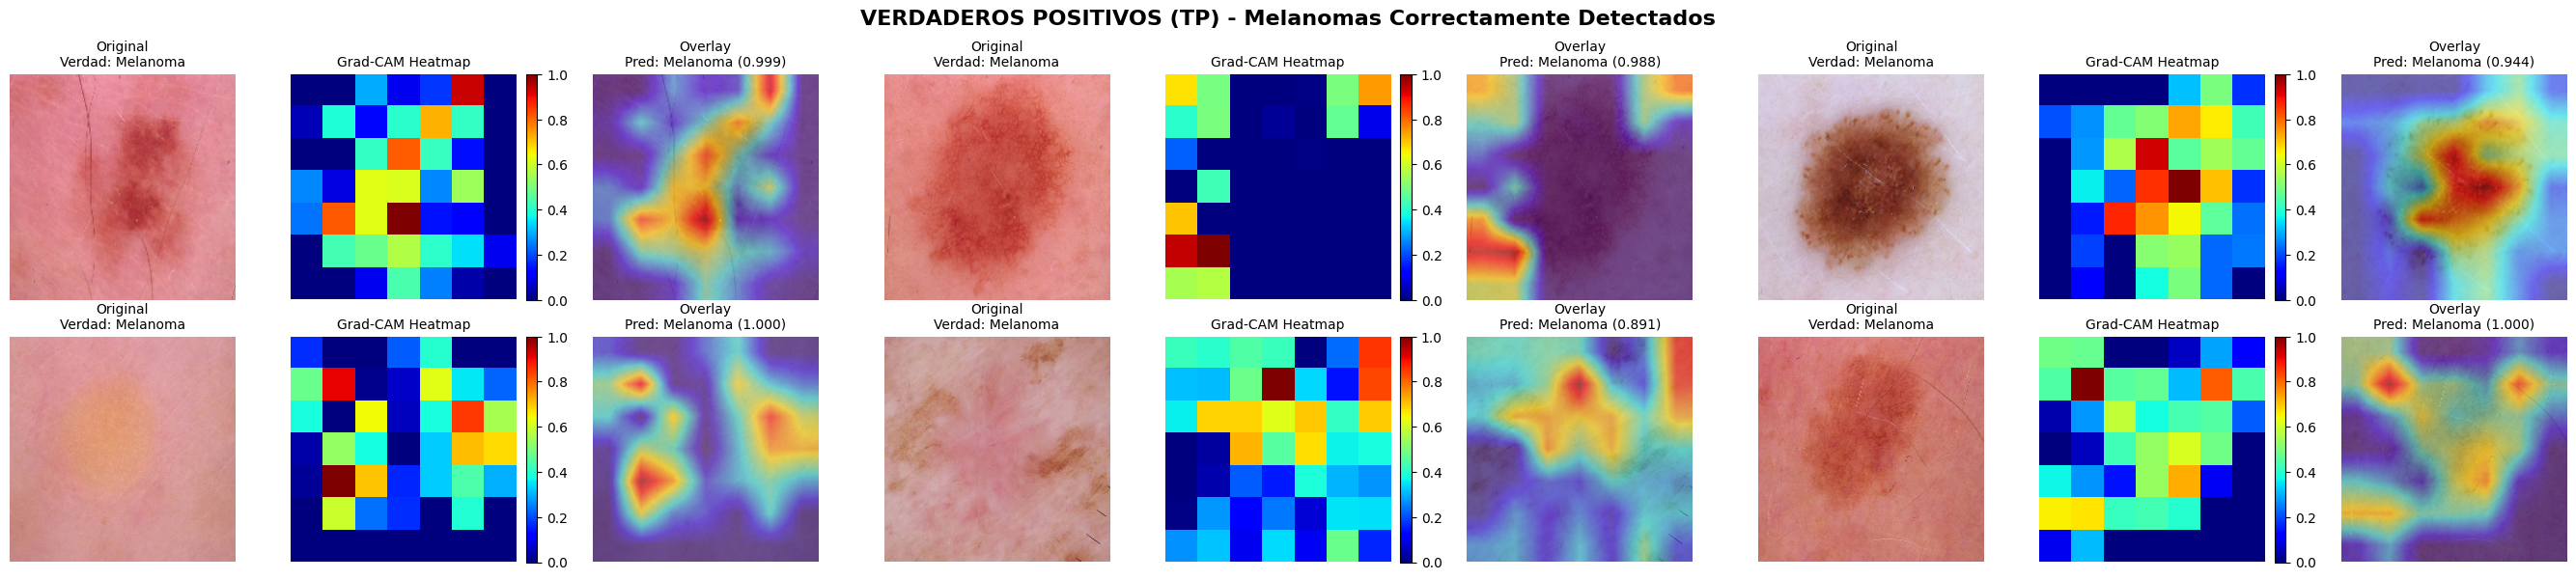

Guardado: gradcam_true_positives.png


In [37]:
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

def visualize_gradcam_cases(cases, X_data, y_true, y_pred_proba, title, 
                           last_conv_layer, model, n_cols=3):
    """
    Visualiza casos con Grad-CAM en una cuadrícula.
    
    Args:
        cases: Índices de los casos a visualizar
        X_data: Imágenes originales
        y_true: Etiquetas verdaderas
        y_pred_proba: Probabilidades predichas
        title: Título de la figura
        last_conv_layer: Nombre de la última capa convolucional
        model: Modelo de Keras
        n_cols: Número de columnas en la cuadrícula
    """
    if len(cases) == 0:
        print(f"No hay casos disponibles para {title}")
        return
    
    n_cases = len(cases)
    n_rows = (n_cases + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols * 3, figsize=(n_cols * 9, n_rows * 3))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    fig.suptitle(title, fontsize=16, fontweight='bold', y=0.98)
    
    for idx, case_idx in enumerate(cases):
        row = idx // n_cols
        col_base = (idx % n_cols) * 3
        
        # Imagen original
        img_original = X_data[case_idx]
        
        # Preprocesar imagen para el modelo
        img_array = np.expand_dims(img_original, axis=0)
        img_preprocessed = preprocess_input(img_array.astype(np.float32))
        
        # Generar Grad-CAM
        heatmap = make_gradcam_heatmap(img_preprocessed, model, last_conv_layer)
        
        # Overlay Grad-CAM
        gradcam_img = overlay_gradcam(img_original, heatmap, alpha=0.5)
        
        # Información de la predicción
        true_label = "Melanoma" if y_true[case_idx] == 1 else "No Melanoma"
        pred_prob = y_pred_proba[case_idx]
        pred_label = "Melanoma" if pred_prob >= best_threshold else "No Melanoma"
        
        # Plotear imagen original
        ax_orig = axes[row, col_base]
        ax_orig.imshow(img_original)
        ax_orig.set_title(f"Original\nVerdad: {true_label}", fontsize=10)
        ax_orig.axis('off')
        
        # Plotear heatmap puro
        ax_heat = axes[row, col_base + 1]
        im = ax_heat.imshow(heatmap, cmap='jet')
        ax_heat.set_title(f"Grad-CAM Heatmap", fontsize=10)
        ax_heat.axis('off')
        plt.colorbar(im, ax=ax_heat, fraction=0.046, pad=0.04)
        
        # Plotear overlay
        ax_overlay = axes[row, col_base + 2]
        ax_overlay.imshow(gradcam_img)
        ax_overlay.set_title(f"Overlay\nPred: {pred_label} ({pred_prob:.3f})", fontsize=10)
        ax_overlay.axis('off')
    
    # Ocultar ejes no utilizados
    for idx in range(n_cases, n_rows * n_cols):
        row = idx // n_cols
        col_base = (idx % n_cols) * 3
        for offset in range(3):
            axes[row, col_base + offset].axis('off')
    
    plt.tight_layout()
    return fig


# Obtener imágenes del conjunto de test SIN preprocesamiento para visualización
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Obtener las rutas de las imágenes del test set
test_filenames = test_generator.filenames
test_dir = os.path.join(dataset_path, 'test')

# Cargar imágenes originales sin preprocesamiento
x_original = []
for filename in test_filenames:
    img_path = os.path.join(test_dir, filename)
    img = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = img_to_array(img)
    x_original.append(img_array)
x_original = np.array(x_original)

# Normalizar a rango [0, 255] para visualización
x = x_original.astype(np.uint8)

print(f"Imágenes cargadas: {len(x)}")
print(f"Rango de valores: [{x.min()}, {x.max()}]")

# Calcular umbral óptimo basado en Youden's Index
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_proba)
youden_index = tpr - fpr
best_threshold_idx = np.argmax(youden_index)
best_threshold = thresholds_roc[best_threshold_idx]

# Generar predicciones binarias con el mejor umbral
y_pred_best = (y_pred_proba >= best_threshold).astype(int)

# Identificar índices de cada tipo de caso
tp_indices = np.where((y_test == 1) & (y_pred_best == 1))[0]
tn_indices = np.where((y_test == 0) & (y_pred_best == 0))[0]
fp_indices = np.where((y_test == 0) & (y_pred_best == 1))[0]
fn_indices = np.where((y_test == 1) & (y_pred_best == 0))[0]

print(f"Umbral óptimo encontrado: {best_threshold:.4f}")
print(f"TP: {len(tp_indices)}, TN: {len(tn_indices)}, FP: {len(fp_indices)}, FN: {len(fn_indices)}")

# Visualizar Verdaderos Positivos
print("\n" + "="*60)
print("GENERANDO VISUALIZACIONES GRAD-CAM")
print("="*60)
print("\nProcesando Verdaderos Positivos (TP)...")

# Seleccionar hasta 6 casos para visualizar
tp_to_show = tp_indices[:6] if len(tp_indices) > 6 else tp_indices

fig_tp = visualize_gradcam_cases(
    tp_to_show, x, y_test, y_pred_proba,
    "VERDADEROS POSITIVOS (TP) - Melanomas Correctamente Detectados",
    last_conv_layer_name, best_model, n_cols=3
)

if fig_tp:
    plt.savefig('gradcam_true_positives.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("Guardado: gradcam_true_positives.png")

### 4.4 Verdaderos Negativos (TN) - No Melanomas Correctamente Clasificados


Procesando Verdaderos Negativos (TN)...


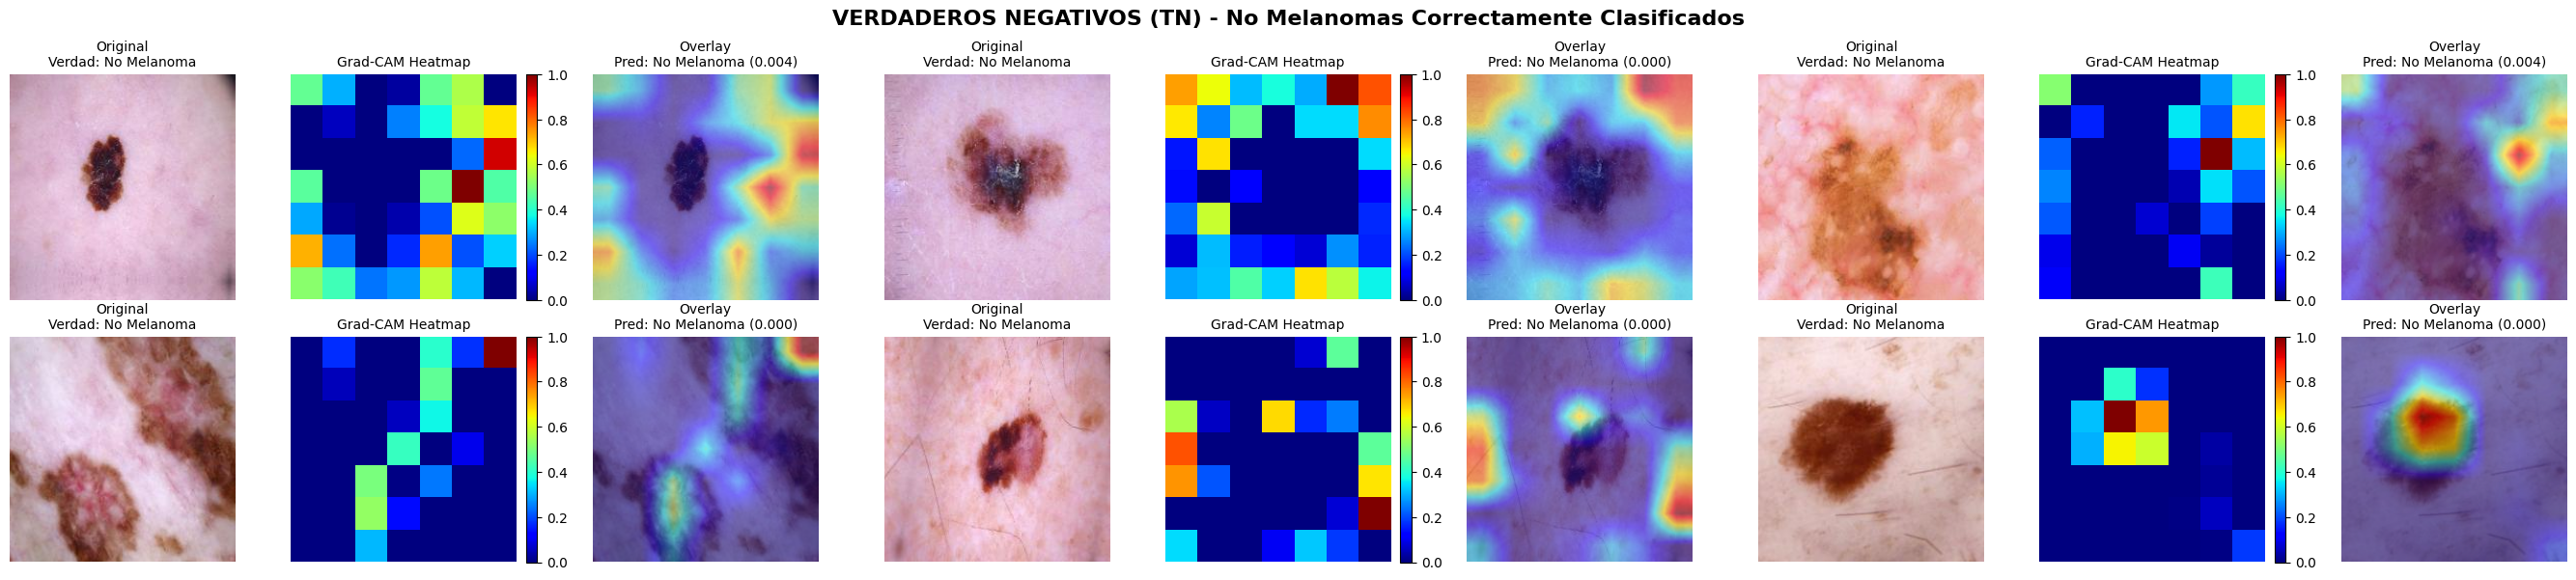

Guardado: gradcam_true_negatives.png


In [38]:
# Visualizar Verdaderos Negativos
print("\nProcesando Verdaderos Negativos (TN)...")

# Seleccionar hasta 6 casos para visualizar
tn_to_show = tn_indices[:6] if len(tn_indices) > 6 else tn_indices

fig_tn = visualize_gradcam_cases(
    tn_to_show, x, y_test, y_pred_proba,
    "VERDADEROS NEGATIVOS (TN) - No Melanomas Correctamente Clasificados",
    last_conv_layer_name, best_model, n_cols=3
)

if fig_tn:
    plt.savefig('gradcam_true_negatives.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("Guardado: gradcam_true_negatives.png")

### 7.4. Análisis de Resultados Grad-CAM

Los mapas de calor muestran qué regiones de la imagen influyen en la predicción:
- **Regiones rojas/amarillas**: Alta influencia (el modelo se enfoca aquí)
- **Regiones azules/frías**: Baja influencia

Para un modelo médicamente confiable, esperamos que se enfoque en:
- Bordes irregulares de la lesión
- Variación de color
- Áreas de pigmentación anómala
